# Prediction pipeline for Kaggle's Titanic dataset

In this notebook we will create a prediction model for Kaggle's Titanic dataset using xgboost library. We will create an sklearn pipeline that contains components of the previous steps we have made: creating new features, imputation and preprocessing. 

In [1]:
import numpy as np
import pandas as pd

import os
import copy
from collections import Counter
from functools import partial
import itertools
import re

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, log_loss
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.svm import SVC, LinearSVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from scipy.stats import uniform


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from imputation_utils import Imputer, GroupByImputer, FamilyAgeImputer
from feature_engineering_utils import grouper, CreateNewFeatures, Preprocessor
from training_utils import (create_test_set, CustomCVSplitter, GenderClassifier, GroupByClassifier,
                            get_failed_predictions, show_slice_results, show_group_predictions,
                           show_results, ModifiedGroupByClassifier)

/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Let's start by specifying the paths and downloading the raw data. Now competition data refers to the final dataset for which we will perform the predictions that Kaggle will evaluate. 

In [2]:
_DATADIR = './data'
_ORIGINAL_TRAIN_DATA = os.path.join(_DATADIR, 'train.csv')
_COMPETITION_DATA = os.path.join(_DATADIR, 'test.csv')
_RESULTDIR = './results'
_MODELDIR = './model'

In [3]:
INDEX = 'PassengerId'
original_train_data = pd.read_csv(_ORIGINAL_TRAIN_DATA).set_index(INDEX)
original_train_data.index = original_train_data.index.astype(str)  # change index to str for xgboost
print(f'Original training data size: {original_train_data.shape}')
_LABEL = 'Survived'

competition_data = pd.read_csv(_COMPETITION_DATA).set_index(INDEX)
competition_data.index = competition_data.index.astype(str)  # change index to str for xgboost
print(f'Competition data size: {competition_data.shape}')

Original training data size: (891, 11)
Competition data size: (418, 10)


Recall from the previous notebooks that we need to specify parameters for the pipeline components we created. Thus we will next specify parameters for feature creation and imputation:

In [4]:
##### Feature creation parameters #####
feature_creation_params = {'group_size_limits': [2, 5, np.inf], 
                           'group_rate_limits': [0.5, np.inf],
                           'family_size_limits': [2, 5, np.inf], 
                           'family_rate_limits': [0.5, np.inf]}


##### Imputation parameters #####

# Age imputation parameters
age_categorical = ['Title_grouped', 'Pclass', 'FamilySize_grouped'] 

age_preprocessing_params = {'categorical_cols': age_categorical, 'numerical_cols': [], 'ordinal_cols': []}

age_imputation_base_method = Pipeline(steps=[
    ('preprocessing', Preprocessor(**age_preprocessing_params)),
    ('regressor', DecisionTreeRegressor(max_depth=5))
    ])

# Define imputation methods for other columns as well
col_imputation_methods = {
                  'Embarked': GroupByImputer('Embarked', ['Pclass'], lambda x: pd.Series.mode(x)[0]),
                  'Fare': GroupByImputer('Fare', ['Pclass', 'HasCabin'], pd.Series.median),
                  'Fare_adjusted': GroupByImputer('Fare_adjusted', ['Pclass', 'HasCabin'], pd.Series.median),
                  'Age': FamilyAgeImputer(base_imputation_method=age_imputation_base_method)
                  }


__features_imputation_pipeline__ is used to create imputed data that has all features created. Preprocessing step is not applied so categorical variables are not yet one-hot encoded and numerical variables are not yet standardized. We will see that this kind of data is "the easiest to read" when investigating which datapoints were not classified correctly, for example. Also this data is useful when we want to split data to proper train and test set using all the features.

In [5]:
features_imputation_pipeline = Pipeline(steps=[
    ('creating_features', CreateNewFeatures(**feature_creation_params)),
    ('imputing', Imputer(col_imputation_methods=col_imputation_methods))
    ])

Let's create then imputed training and competition data with all features:

In [6]:
features_imputation_pipeline.fit(original_train_data, original_train_data['Survived'])
all_features_training_data = features_imputation_pipeline.transform(original_train_data)
all_features_competition_data = features_imputation_pipeline.transform(competition_data)
all_features_competition_data

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,Title_grouped,FamilySize,FamilySize_grouped,GroupSize,GroupSize_grouped,GroupRate,GroupRate_grouped,FamilyRate,FamilyRate_grouped,Fare_adjusted
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.8292,NaN,Q,...,Mr,1,0,1,0,0.155718,0,0.155718,0,7.829200
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.0000,NaN,S,...,Mrs,2,1,2,1,0.785714,1,0.785714,1,3.500000
894,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.6875,NaN,Q,...,Mr,1,0,1,0,0.155718,0,0.155718,0,9.687500
895,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.6625,NaN,S,...,Mr,1,0,1,0,0.155718,0,0.155718,0,8.662500
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.2875,NaN,S,...,Mrs,3,1,3,1,0.785714,1,0.785714,1,4.095833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,28.724891,0,0,A.5. 3236,8.0500,NaN,S,...,Mr,1,0,1,0,0.155718,0,0.155718,0,8.050000
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,...,Other,1,0,3,1,0.500000,1,0.785714,1,36.300000
1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,...,Mr,1,0,1,0,0.155718,0,0.155718,0,7.250000


Let's split the training data to actual training data (including also the validation sets) and test set. 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(all_features_training_data, 
                                                    all_features_training_data[_LABEL], 
                                                    stratify=all_features_training_data[_LABEL],
                                                    test_size=0.2, random_state=1)

Before moving any further we can test what accuracy some simple benchmark classifiers achieve in training and test sets compared to Kaggle competition dataset. Let's use GenderClassifier and more general GroupByClassifier as benchmark classifiers. GenderClassifier make predictions only based on gender: survived for female and not survived for male. GroupByClassifier, at fit time,  groups training data based on groupby_cols and calculates average survival rate for each group. If rate >= 0.5 it will predict that passengers in that group will survive and otherwise not. For more details, see code of these classifiers in training_utils.py.

And here are the results:

In [8]:
gender_clf = GenderClassifier()
gender_clf.fit(X_train, y_train)
print(f'Score in training set (fit): {gender_clf.score(X_train, y_train)}')
print(f'Score in test set: {gender_clf.score(X_test, y_test)}')
print(f'Kaggle score: {0.76555}')

Score in training set (fit): 0.7823033707865169
Score in test set: 0.8044692737430168
Kaggle score: 0.76555


In [9]:
groupby_clf = GroupByClassifier(['Title_grouped', 'FamilySize_grouped']).fit(X_train, y_train)
print(f'Score in training set (fit): {groupby_clf.score(X_train, y_train)}')
print(f'Score in test set: {groupby_clf.score(X_test, y_test)}')
print(f'Kaggle score: {0.77033}')

Score in training set (fit): 0.8230337078651685
Score in test set: 0.8324022346368715
Kaggle score: 0.77033


In [10]:
groupby_clf = GroupByClassifier(['Title_grouped', 'FamilyRate_grouped']).fit(X_train, y_train)
print(f'Score in training set (fit): {groupby_clf.score(X_train, y_train)}')
print(f'Score in test set: {groupby_clf.score(X_test, y_test)}')
print(f'Kaggle score: {0.77751}')

Score in training set (fit): 0.8553370786516854
Score in test set: 0.8603351955307262
Kaggle score: 0.77751


In [11]:
groupby_clf = GroupByClassifier(['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped']).fit(X_train, y_train)
print(f'Score in training set (fit): {groupby_clf.score(X_train, y_train)}')
print(f'Score in test set: {groupby_clf.score(X_test, y_test)}')
print(f'Kaggle score: {0.77990}')

Score in training set (fit): 0.8609550561797753
Score in test set: 0.8603351955307262
Kaggle score: 0.7799


In [12]:
groupby_clf = GroupByClassifier(['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped', 
                                 'GroupSize_grouped', 'GroupRate_grouped', 'Sex']).fit(X_train, y_train)
print(f'Score in training set (fit): {groupby_clf.score(X_train, y_train)}')
print(f'Score in test set: {groupby_clf.score(X_test, y_test)}')
print(f'Kaggle score: {0.76076}')


Score in training set (fit): 0.8651685393258427
Score in test set: 0.8770949720670391
Kaggle score: 0.76076


It looks like Kaggle score is much lower than score in test/train set. It seems also that higher score in test set doesn't imply higher Kaggle score. This is a problem because we usually want to select the classifier with the highest score in test set (if not too bad overfitting occurs) as our final estimator. Without a proper test set it is impossible to get any insight on how the model will work on production data. In this notebook we are not playing with real production data but our goal is to predict competition data as accurately as possible as if it was production data. 

One possible way to reduce this is paying more attention to the test set distribution. Because it's the performance on production data (or now competition data) that really matters, the test set should be as close as possible to the competition data. When test set is properly formed, performance in test set will be a proxy for performance on competition data and there is a clear goal where to aim for. Above we just created the stratified train-test split randomly with train_test_split() but we could try to mimic the competition data when creating test set. 

Thus, we will now create test set using create_test_set() funtion (see more details in training_utils.py). It produces a test set by selecting rows from training data in a such way that proportions of passengers with certain key characteristics are as close as possible to the corresponding proportions in competition data. The key characteristics are now determined by groupby_cols. 

For example, with groupby_cols=['Sex', 'HasCabin'] create_test_set() would select test set so that proportion of passengers with Sex=x and HasCabin=y would be as similar as possible in test and competition data. More specifically, create_test_set() will formulate and solve a MILP problem so that proportions of passengers with 
1) (Sex=female & HasCabin=0),  
2) (Sex=female & HasCabin=1),      
3) (Sex=male & HasCabin=0),    
4) (Sex=male & HasCabin=1)   

will be as similar as possible in both data sets. Now we will try 'Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped' and 'GroupRate_grouped' as groupby_cols. We will also use data created by features_imputation_pipeline instead of raw data because the selected data has all features created.

In [13]:
target_data = all_features_competition_data  # data to mimic
source_data = all_features_training_data.copy(deep=True)  # data to choose test set from
test_set_size = int(0.2*source_data.shape[0])  # desired test set size
print(f'Desired test set size: {test_set_size}')

# features to use as key characteristics
groupby_cols = ['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped', 'GroupRate_grouped']  

train_indices, test_indices = create_test_set(target_data, source_data, test_set_size, groupby_cols, 
                                              print_output=True)

X_train = source_data.iloc[train_indices]
X_test = source_data.iloc[test_indices]
y_train = source_data.iloc[train_indices][_LABEL]
y_test = source_data.iloc[test_indices][_LABEL]

print(f'Created test set size: {X_test.shape[0]}')
print(f'Created train set size: {X_train.shape[0]}')

Desired test set size: 178
Number of variables = 951
Number of constraints = 62
Objective value = 10.939999999999912
Problem solved in 6994.000000 milliseconds
Problem solved in 14365 iterations
Problem solved in 842 branch-and-bound nodes
Created test set size: 178
Created train set size: 713


Data is now split to train and test sets. There were 951 variables in the optimization task, but fortunately, it was solved pretty quickly. Let's compare the proportions of different keys in competition and test sets:

In [14]:
target_groups = target_data.groupby(groupby_cols)
target_data_proportions = np.round(target_groups['Name'].count() / target_data.shape[0], 3)
test_data_proportions = np.round(X_test.groupby(groupby_cols)['Name'].count() / X_test.shape[0], 3)
all_keys = set(target_data_proportions.keys()).union(set(test_data_proportions.keys()))

comparison_df = pd.DataFrame(index=all_keys, columns=['Target data', 'Test data'])
for key in all_keys:
    comparison_df.loc[key, :] = (target_data_proportions.get(key, 0), test_data_proportions.get(key, 0))

print('Proportions of keys in target and test data: \n')
comparison_df.sort_index()

Proportions of keys in target and test data: 



Target data Test data
Master    0 0 0       0.002         0
          1 0 0       0.026     0.011
              1       0.002         0
            1 1       0.005     0.006
          2 0 0       0.007     0.006
            1 1       0.007     0.006
Miss      0 1 0       0.002         0
              1       0.117     0.118
          1 0 0       0.002         0
            1 0           0     0.006
              1       0.055     0.056
          2 0 0       0.005     0.006
            1 1       0.005     0.006
Mr        0 0 0       0.428     0.427
              1       0.007     0.006
            1 1           0     0.006
          1 0 0       0.108     0.107
              1        0.01     0.011
            1 1       0.007     0.006
          2 0 0        0.01     0.011
            1 1       0.005     0.006
Mrs       0 1 0           0     0.006
              1       0.038     0.039
          1 0 0       0.002         0
              1           0     0.006
            1 1       0.122     0.124
          2 0 0       0.005     0.006
            1 1       0.005     0.006
Other     0 0 0       0.002         0
            1 1       0.005     0.006
          1 0 0       0.002         0
              1       0.002         0
            1 1           0     0.006
Religious 0 0 0       0.002         0
          1 0 0       0.002         0
            1 1           0     0.006

Looks like the proportions match quite nicely! Let's quickly check also that proportions of Survived are roughly equal in train and test sets:

In [15]:
print(f'Proportions of survived in train data: {np.mean(y_train)}')
print(f'Proportions of survived in test data: {np.mean(y_test)}')

Proportions of survived in train data: 0.3744740532959327
Proportions of survived in test data: 0.42134831460674155


It seems survival rates are quite close to each others in train and test data. If this difference appears to be a problem, then we can add survival rate difference of train and test set to objective function of the optimization when creating test set so that rates would be closer. Nevertheless, let's see how the simple classifiers perform now in this train-test split:


In [16]:
gender_clf = GenderClassifier()
gender_clf.fit(X_train, y_train)
print(f'Score in training set: {gender_clf.score(X_train, y_train)}')
print(f'Score in test set: {gender_clf.score(X_test, y_test)}')
print(f'Kaggle score: {0.76555}')

Score in training set: 0.7769985974754559
Score in test set: 0.8258426966292135
Kaggle score: 0.76555


In [17]:
groupby_clf = GroupByClassifier(['Title_grouped', 'FamilySize_grouped']).fit(X_train, y_train)
print(f'Score in training set (fit): {groupby_clf.score(X_train, y_train)}')
print(f'Score in test set: {groupby_clf.score(X_test, y_test)}')
print(f'Kaggle score: {0.77033}')

Score in training set (fit): 0.820476858345021
Score in test set: 0.8370786516853933
Kaggle score: 0.77033


In [18]:
groupby_clf = GroupByClassifier(['Title_grouped', 'FamilyRate_grouped']).fit(X_train, y_train)
print(f'Score in training set: {groupby_clf.score(X_train, y_train)}')
print(f'Score in test set: {groupby_clf.score(X_test, y_test)}')
print(f'Kaggle score: {0.77751}')

Score in training set: 0.8583450210378681
Score in test set: 0.848314606741573
Kaggle score: 0.77751


In [19]:
groupby_clf = GroupByClassifier(['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped']).fit(X_train, y_train)
print(f'Score in training set: {groupby_clf.score(X_train, y_train)}')
print(f'Score in test set: {groupby_clf.score(X_test, y_test)}')
print(f'Kaggle score: {0.77990}')


Score in training set: 0.8653576437587658
Score in test set: 0.848314606741573
Kaggle score: 0.7799


In [20]:
groupby_clf = GroupByClassifier(['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped', 
                                 'GroupSize_grouped', 'GroupRate_grouped', 'Sex']).fit(X_train, y_train)
print(f'Score in training set: {groupby_clf.score(X_train, y_train)}')
print(f'Score in test set: {groupby_clf.score(X_test, y_test)}')
print(f'Kaggle score: {0.76076}')


Score in training set: 0.8709677419354839
Score in test set: 0.8370786516853933
Kaggle score: 0.76076


It looks like Kaggle score is still much lower than test score even though we focused on selecting test set that is as close as possible to competition data. On the bright side, it looks like score in test set reflects now better the Kaggle score although the absolute score is shifted. It could be that Kaggle score is based on a subset of competition data that has very different distributions and that's why we get the differences. Another possible explanation is that our selected key characteristics are not explaining the data perfectly and there might be a lot of variation even inside the key groups. All in all, we seem to have now better test set so let's see if test set works in the case of more advanced classifiers as well.

__Estimator pipeline__

Let's make now pipeline with estimator that does predictions based on the imputed data with all features. The first component is Preprocessor that we saw in feature_engineering notebook. We import it from feature_engineering_utils.py and we have to specify the column types for it:

In [21]:
##### Preprocessing parameters #####
categorical = ['Title_grouped', 'Pclass', 'FamilySize_grouped', 'FamilyRate_grouped', 
               'GroupSize_grouped', 'GroupRate_grouped', 'HasCabin', 'Embarked', 'Sex']  
numerical = ['Age', 'Fare', 'Fare_adjusted', 'GroupRate', 'FamilyRate']
ordinal = []

preprocessing_params = {'categorical_cols': categorical, 'numerical_cols': numerical, 'ordinal_cols': ordinal
                       }

Then we add component that does Factorial Analysis of Mixed Data (FAMD) (see https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210 for more details) before we apply Principal Component Analysis (PCA) to the data. Usually PCA is done for numerical data but it's interesting to test how FAMD works in making categorical variables applicable to PCA. 


In [22]:
class FAMD(BaseEstimator, TransformerMixin):
    def __init__(self, tol=0.001):
        self.tol = tol
    
    def fit(self, X, y=None):
        self.numerical = [col for col in X.columns if 'num__' in col]
        self.categorical = [col for col in X.columns if 'cat__' in col]
        self.categorical_squared_means = np.sqrt(X.loc[:, self.categorical].mean()) + self.tol
        return self
    
    def transform(self, X):
        X_copy = X.copy(deep=True)
        # centering of data not done as PCA can do that
        X_copy.loc[:, self.categorical] = X_copy.loc[:, self.categorical] / self.categorical_squared_means
        return X_copy

The idea of PCA is to reduce the dimensionality of data before we input it to classifier by selecting only the components that explain the most of the variance in data. We could reduce features already using sklearn's PCA() by using n_components parameter but this time we just use PCA() to transform the data and then we select features using another component.

We will also add a simple feature selection component to the pipeline. It uses the standard sklearn SelectPercentile feature selection method but it returns resulting columns in pd.DataFrame:

In [23]:
class FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, **params):
        self.selector = SelectPercentile(**params)
    
    def get_params(self, deep=True):
        return self.selector.get_params(deep)
    
    def set_params(self, **params):
        self.selector.set_params(**params)
    
    def fit(self, X, y=None):
        self.selector.fit(X, y)
        return self
    
    def transform(self, X):
        transformed_X = self.selector.transform(X)
        return pd.DataFrame(transformed_X, columns=self.selector.get_feature_names_out())


Then we can combine all components to a pipeline: __estimator_pipeline__ contains preprocessing, FAMD, PCA, feature selection and the estimator steps. Now we use XGBClassifier of xgboost library as estimator. Recall that this pipeline produces the predictions based on the data created by __features_imputation_pipeline__.


In [24]:
estimator_pipeline = Pipeline(steps=[
    ('preprocessing', Preprocessor(**preprocessing_params)),
    ('pca_preprocessing', FAMD()),
    ('pca', PCA()),
    ('feature_selection', FeatureSelection()),
    ('estimator', XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='error'))
    ])

Note that __features_imputation_pipeline__ and __estimator_pipeline__ could be combined to a single pipeline that can form predictions from raw data. Now (to save time) we don't want the __features_imputation_pipeline__ to be part of the tuned pipeline so we will consider them as separate pipelines. 

Let's now train our estimator pipeline with XGBClassifier using training data and evaluate the performance in test set to see if we can outperform the simple benchmark classifiers. We will try different hyperparameter values using RandomizedSearchCV: it will perform 5-fold cross-validation for each sampled parameter combination and it selects the parameter combination that has best score in validation sets as final set of parameters. We specify different parameter ranges/lists in 'distributions' dictionary.

In [25]:
distributions = {
             'feature_selection__percentile': [50, 60, 70, 80],
             'estimator__max_depth': [3, 4, 5], 
             'estimator__n_estimators': [1000], 
             'estimator__learning_rate': [0.01, 0.001, 0.0001], 
             'estimator__subsample': uniform(loc=0.1, scale=0.5),
             'estimator__colsample_bytree': uniform(loc=0.3, scale=0.5),
             'estimator__reg_lambda': [0.1, 1.0, 10],
             'estimator__gamma': uniform(loc=0.0, scale=0.5),
             'estimator__scale_pos_weight': uniform(loc=1.0, scale=1.5)
             }

cv = StratifiedKFold(n_splits=5)
search = RandomizedSearchCV(estimator_pipeline, param_distributions=distributions, 
                        n_iter=30, n_jobs=-1, cv=cv, verbose=0, scoring=['accuracy'], refit='accuracy',
                       random_state=1)
search.fit(X_train, y_train)
best_pipeline = search.best_estimator_


/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Estimator pipeline is now trained and some small scale hyperparameter tuning is also done. Let's see the results in validation sets and test set now:

In [26]:
show_results(best_pipeline, search, X_train, y_train, X_test, y_test)

############ Parameters ################

Best parameters: 

estimator__colsample_bytree: 0.3716315030807043
estimator__gamma: 0.4655064666251126
estimator__learning_rate: 0.01
estimator__max_depth: 4
estimator__n_estimators: 1000
estimator__reg_lambda: 0.1
estimator__scale_pos_weight: 1.3949451557306665
estimator__subsample: 0.1329805453420119
feature_selection__percentile: 80


Best accuracy in validation sets: 0.8766078991431104

############ Results in training set (refit after cv) ################

Accuracy: 0.9214586255259467

Log loss: 0.21280883236652368

Precision: 0.8921933085501859, Recall: 0.898876404494382, F-score: 0.8955223880597014

Confusion matrix: 

         Pred_0  Pred_1
True_0     417      29
True_1      27     240

############ Results in test set ################

Accuracy: 0.848314606741573

Log loss: 0.41894116504065526

Precision: 0.8243243243243243, Recall: 0.8133333333333334, F-score: 0.8187919463087249

Confusion matrix: 

         Pred_0  Pred_1
True_0   

The shortly tuned Estimator pipeline got average accuracy of 0.871 in 5 validation sets of StratifiedKFold. It also got excellent accuracy (0.865) in test set. Printing results in full X_train after refit gives accuracy of 0.944, which is much higher than in test set. Let's see if this will cause some overfitting problems! The test set score is still the highest we had got (together with best benchmark classifier), so we can try sending the competition data predictions to Kaggle and see the results.

__Kaggle shows score 0.76076__ which is even worse than the GenderClassifier got so we have some tough problems to solve! It looks like our test set is not a perfect proxy for competition data as we already a bit suspected when evaluating benchmark classifier scores. We could try different key characteristics or logic for selecting the test set. It also seems like there are some (possibly random) survival patterns that are present in train+test set but not in the subset of competition data that Kaggle evaluates. It is out of scope of this project to start investigating that subset but one possible way to tackle this is to use less features for our classifier. This could prevent overfitting and thus produce results that may perform better in Kaggle's subset.

So, let's start by selecting the same features as the GroupByClassifier with best Kaggle score used: 'Title_grouped', 'FamilySize_grouped' and 'FamilyRate_grouped'. To be able to select columns of preprocessed data that are only related to those columns we create a new pipeline component called CustomFeatureSelection:


In [27]:
class CustomFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        #  select columns that have one of self.columns in their name
        self.selected_columns = [full_col for full_col in X.columns for col in self.columns if col in full_col]
        return self
    
    def transform(self, X):
        transformed_X = X.copy(deep=True).loc[:, self.selected_columns]
        return transformed_X


Then we add the new component to our pipeline (PCA related steps are removed now):

In [28]:
estimator_pipeline = Pipeline(steps=[
    ('preprocessing', Preprocessor(**preprocessing_params)),
    ('feature_selection', CustomFeatureSelection(columns=[])),
    ('estimator', XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='error'))
    ])

Let's train the estimator pipeline now again and see if the overfitting is reduced:

In [29]:
distributions = {
             'feature_selection__columns': [['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped']],
             'estimator__max_depth': [3, 4, 5], 
             'estimator__n_estimators': [500, 1000], 
             'estimator__learning_rate': [0.01, 0.001, 0.0001], 
             'estimator__subsample': uniform(loc=0.1, scale=0.5),
             'estimator__colsample_bytree': uniform(loc=0.3, scale=0.5),
             'estimator__reg_lambda': [0.1, 1.0, 10],
             'estimator__gamma': uniform(loc=0.0, scale=0.5),
             'estimator__scale_pos_weight': uniform(loc=1.0, scale=1.5)
             }

cv = StratifiedKFold(n_splits=5)
search = RandomizedSearchCV(estimator_pipeline, param_distributions=distributions, 
                        n_iter=30, n_jobs=-1, cv=cv, verbose=0, scoring=['accuracy'], refit='accuracy',
                       random_state=1)
search.fit(X_train, y_train)
best_pipeline = search.best_estimator_

/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [30]:
show_results(best_pipeline, search, X_train, y_train, X_test, y_test)

############ Parameters ################

Best parameters: 

estimator__colsample_bytree: 0.5336963415735261
estimator__gamma: 0.134500525628914
estimator__learning_rate: 0.01
estimator__max_depth: 4
estimator__n_estimators: 1000
estimator__reg_lambda: 0.1
estimator__scale_pos_weight: 1.2585107625179928
estimator__subsample: 0.16856787481443888
feature_selection__columns: ['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped']


Best accuracy in validation sets: 0.85976558652615

############ Results in training set (refit after cv) ################

Accuracy: 0.8583450210378681

Log loss: 0.3867390405381462

Precision: 0.8705357142857143, Recall: 0.7303370786516854, F-score: 0.794297352342159

Confusion matrix: 

         Pred_0  Pred_1
True_0     417      29
True_1      72     195

############ Results in test set ################

Accuracy: 0.8426966292134831

Log loss: 0.4306555547113164

Precision: 0.8405797101449275, Recall: 0.7733333333333333, F-score: 0.8055555555555556



At least it seems there is no severe overfitting present. Kaggle score is now also slightly better than with the features the previous estimator used: 0.77751, but there is still things to improve as one of our benchmark classifier still outperforms our estimator pipeline. Let's first see the accuracy of predictions for different passenger titles in train and test sets. The results are represented as a 3-tuple for each group: 1st element tells proportion, 2nd element tells count of positives and 3rd element tells the total count of passengers in that group. For more details about show_slice_results, see training_utils.py.

In [31]:
show_slice_results(best_pipeline, X_train, y_train, ['Title_grouped'])
show_slice_results(best_pipeline, X_test, y_test, ['Title_grouped'])

,Survived,Predictions,Failure
Title_grouped,,,
Master,"(0.57, 20.0, 35)","(0.51, 18.0, 35)","(0.06, 2.0, 35)"
Miss,"(0.68, 102.00000000000001, 150)","(0.83, 125.0, 150)","(0.15, 23.0, 150)"
Mr,"(0.16, 66.0, 414)","(0.0, 0.0, 414)","(0.16, 66.0, 414)"
Mrs,"(0.77, 72.0, 93)","(0.82, 76.0, 93)","(0.04, 4.0, 93)"
Other,"(0.44, 7.0, 16)","(0.31, 5.0, 16)","(0.38, 6.0, 16)"
Religious,"(0.0, 0.0, 5)","(0.0, 0.0, 5)","(0.0, 0.0, 5)"


,Survived,Predictions,Failure
Title_grouped,,,
Master,"(0.6, 3.0, 5)","(0.4, 2.0, 5)","(0.6, 3.0, 5)"
Miss,"(0.79, 27.0, 34)","(0.97, 33.0, 34)","(0.18, 6.0, 34)"
Mr,"(0.15, 14.999999999999998, 103)","(0.0, 0.0, 103)","(0.15, 14.999999999999998, 103)"
Mrs,"(0.85, 28.0, 33)","(0.94, 31.0, 33)","(0.09, 3.0, 33)"
Other,"(1.0, 2.0, 2)","(1.0, 2.0, 2)","(0.0, 0.0, 2)"
Religious,"(0.0, 0.0, 1)","(1.0, 1.0, 1)","(1.0, 1.0, 1)"


In test set it seems like 'Master' and 'Religious' groups were the most difficult, but they had only a few members. We can see also that in training set (above table) title group 'Other' was clearly the most difficult one to predict (38%=6/16 predictions failed). However, improving prediction accuracy for larger title groups, such as 'Mr' and 'Miss', would probably be the faster way to get better results. It may be difficult to get improvements to these groups though.

One small thing we can try to improve results is to split 'Other' group to 'Mr', 'Miss' and 'Mrs' groups. This could potentially improve accuracy of the benchmark classifier as well.

Let's try that next, by setting split_other_title=True in CreateNewFeatures component (see feature_engineering_utils.py for details):

In [32]:
##### Feature creation parameters #####
feature_creation_params = {'group_size_limits': [2, 5, np.inf], 
                           'group_rate_limits': [0.5, np.inf],
                           'family_size_limits': [2, 5, np.inf], 
                           'family_rate_limits': [0.5, np.inf],
                           'split_other_title': True}

In [33]:
features_imputation_pipeline = Pipeline(steps=[
    ('creating_features', CreateNewFeatures(**feature_creation_params)),
    ('imputing', Imputer(col_imputation_methods=col_imputation_methods))
    ])

Because of this change we have to from all_features_training_data and all_features_competition_data again. We also have to make a new test set:

In [34]:
features_imputation_pipeline.fit(original_train_data, original_train_data['Survived'])
all_features_training_data = features_imputation_pipeline.transform(original_train_data)
all_features_competition_data = features_imputation_pipeline.transform(competition_data)

target_data = all_features_competition_data  # data to mimic
source_data = all_features_training_data.copy(deep=True)  # data to choose test set from
test_set_size = int(0.2*source_data.shape[0])  # desired test set size
print(f'Desired test set size: {test_set_size}')

# features to use as key characteristics
groupby_cols = ['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped', 'GroupRate_grouped']  


train_indices, test_indices = create_test_set(target_data, source_data, test_set_size, groupby_cols, 
                                              print_output=True)

X_train = source_data.iloc[train_indices]
X_test = source_data.iloc[test_indices]
y_train = source_data.iloc[train_indices][_LABEL]
y_test = source_data.iloc[test_indices][_LABEL]

print(f'Created test set size: {X_test.shape[0]}')
print(f'Created train set size: {X_train.shape[0]}')

Desired test set size: 178
Number of variables = 943
Number of constraints = 54
Objective value = 9.860000000000014
Problem solved in 161.000000 milliseconds
Problem solved in 821 iterations
Problem solved in 1 branch-and-bound nodes
Created test set size: 178
Created train set size: 713


Now we can check if new test data has roughly the same proportions of key characteristics as competition data:

In [35]:
target_groups = target_data.groupby(groupby_cols)
target_data_proportions = np.round(target_groups['Name'].count() / target_data.shape[0], 3)
test_data_proportions = np.round(X_test.groupby(groupby_cols)['Name'].count() / X_test.shape[0], 3)
all_keys = set(target_data_proportions.keys()).union(set(test_data_proportions.keys()))

comparison_df = pd.DataFrame(index=all_keys, columns=['Target data', 'Test data'])
for key in all_keys:
    comparison_df.loc[key, :] = (target_data_proportions.get(key, 0), test_data_proportions.get(key, 0))

print('Proportions of keys in target and test data: \n')
comparison_df.sort_index()

Proportions of keys in target and test data: 



Target data Test data
Master    0 0 0       0.002         0
          1 0 0       0.026     0.011
              1       0.002         0
            1 1       0.005     0.006
          2 0 0       0.007     0.006
            1 1       0.007     0.006
Miss      0 1 0       0.002         0
              1       0.122     0.124
          1 0 0       0.002         0
            1 0           0     0.006
              1       0.055     0.056
          2 0 0       0.005     0.006
            1 1       0.005     0.006
Mr        0 0 0       0.431     0.433
              1       0.007     0.006
            1 1           0     0.006
          1 0 0        0.11     0.112
              1       0.012     0.011
            1 0           0     0.006
              1       0.007     0.006
          2 0 0        0.01     0.011
            1 1       0.005     0.006
Mrs       0 1 1       0.038     0.039
          1 0 0       0.002         0
            1 1       0.122     0.124
          2 0 0       0.005     0.006
            1 1       0.005     0.006
Religious 0 0 0       0.002         0
          1 0 0       0.002         0
            1 1           0     0.006

Looks ok! Now we have to recalculate the benchmark scores as well because we have a different test set. Let's see the results of the previously best GroupByClassifier in train and test set:

In [36]:
groupby_clf = GroupByClassifier(['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped']).fit(X_train, y_train)
print(f'Score in training set: {groupby_clf.score(X_train, y_train)}')
print(f'Score in test set: {groupby_clf.score(X_test, y_test)}')
print(f'Kaggle score: {0.77990}')

Score in training set: 0.8625525946704067
Score in test set: 0.8595505617977528
Kaggle score: 0.7799


Now we have a new reference that we can try to beat! Let's see how XGBClassifier now works:

In [37]:
estimator_pipeline = Pipeline(steps=[
    ('preprocessing', Preprocessor(**preprocessing_params)),
    ('feature_selection', CustomFeatureSelection(columns=[])),
    ('estimator', XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='error'))
    ])

distributions = {
             'feature_selection__columns': [['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped']],
             'estimator__max_depth': [3, 4, 5], 
             'estimator__n_estimators': [5000], 
             'estimator__learning_rate': [0.01, 0.001, 0.0001], 
             'estimator__subsample': uniform(loc=0.1, scale=0.7),
             'estimator__colsample_bytree': uniform(loc=0.3, scale=0.5),
             'estimator__reg_lambda': [0.1, 1.0, 10],
             'estimator__gamma': uniform(loc=0.0, scale=0.5),
             'estimator__scale_pos_weight': uniform(loc=1.0, scale=1.5)
             }

cv = StratifiedKFold(n_splits=5)
search = RandomizedSearchCV(estimator_pipeline, param_distributions=distributions, 
                        n_iter=30, n_jobs=-1, cv=cv, verbose=0, scoring=['accuracy'], refit='accuracy',
                       random_state=1)
search.fit(X_train, y_train)
best_pipeline = search.best_estimator_

/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarn

/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarn

/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarn

/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [38]:
show_results(best_pipeline, search, X_train, y_train, X_test, y_test)


############ Parameters ################

Best parameters: 

estimator__colsample_bytree: 0.508511002351287
estimator__gamma: 0.36016224672107905
estimator__learning_rate: 0.001
estimator__max_depth: 4
estimator__n_estimators: 5000
estimator__reg_lambda: 0.1
estimator__scale_pos_weight: 1.1385078921531968
estimator__subsample: 0.23038214796436962
feature_selection__columns: ['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped']


Best accuracy in validation sets: 0.859755737220526

############ Results in training set (refit after cv) ################

Accuracy: 0.8597475455820477

Log loss: 0.3894685281004344

Precision: 0.8878923766816144, Recall: 0.7252747252747253, F-score: 0.7983870967741935

Confusion matrix: 

         Pred_0  Pred_1
True_0     415      25
True_1      75     198

############ Results in test set ################

Accuracy: 0.8426966292134831

Log loss: 0.4266124821445915

Precision: 0.8059701492537313, Recall: 0.782608695652174, F-score: 0.794117647058823

Now XGBClassifier couldn't outperform benchmark classifier in test set and Kaggle score told the same story: 0.77751. We can check the slice results again to get better insight where we could still improve:

In [39]:
show_slice_results(best_pipeline, X_train, y_train, ['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped'])
show_slice_results(best_pipeline, X_test, y_test, ['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped'])

Survived  \
Title_grouped FamilySize_grouped FamilyRate_grouped                      
Master        1                  0                       (1.0, 2.0, 2)   
                                 1                     (1.0, 17.0, 17)   
              2                  0                      (0.0, 0.0, 15)   
                                 1                       (1.0, 1.0, 1)   
Miss          0                  1                    (0.77, 64.0, 83)   
              1                  0                       (0.0, 0.0, 9)   
                                 1                    (0.95, 37.0, 39)   
              2                  0                      (0.0, 0.0, 16)   
                                 1                       (1.0, 5.0, 5)   
Mr            0                  0                   (0.17, 54.0, 327)   
                                 1                       (0.0, 0.0, 1)   
              1                  0                     (0.12, 5.0, 42)   
                                 1                     (0.3, 14.0, 47)   
              2                  0                       (0.0, 0.0, 7)   
                                 1                       (0.0, 0.0, 1)   
Mrs           0                  1                    (0.86, 12.0, 14)   
              1                  0                      (0.0, 0.0, 12)   
                                 1                    (0.97, 60.0, 62)   
              2                  0                       (0.0, 0.0, 6)   
                                 1                       (1.0, 2.0, 2)   
Religious     0                  0                       (0.0, 0.0, 4)   
              1                  0                       (0.0, 0.0, 1)   

                                                         Predictions  \
Title_grouped FamilySize_grouped FamilyRate_grouped                    
Master        1                  0                     (0.0, 0.0, 2)   
                                 1                   (1.0, 17.0, 17)   
              2                  0                    (0.0, 0.0, 15)   
                                 1                     (1.0, 1.0, 1)   
Miss          0                  1                   (1.0, 83.0, 83)   
              1                  0                     (0.0, 0.0, 9)   
                                 1                   (1.0, 39.0, 39)   
              2                  0                    (0.0, 0.0, 16)   
                                 1                     (1.0, 5.0, 5)   
Mr            0                  0                   (0.0, 0.0, 327)   
                                 1                     (0.0, 0.0, 1)   
              1                  0                    (0.0, 0.0, 42)   
                                 1                    (0.0, 0.0, 47)   
              2                  0                     (0.0, 0.0, 7)   
                                 1                     (0.0, 0.0, 1)   
Mrs           0                  1                   (1.0, 14.0, 14)   
              1                  0                    (0.0, 0.0, 12)   
                                 1                   (1.0, 62.0, 62)   
              2                  0                     (0.0, 0.0, 6)   
                                 1                     (1.0, 2.0, 2)   
Religious     0                  0                     (0.0, 0.0, 4)   
              1                  0                     (0.0, 0.0, 1)   

                                                               Failure  
Title_grouped FamilySize_grouped FamilyRate_grouped                     
Master        1                  0                       (1.0, 2.0, 2)  
                                 1                      (0.0, 0.0, 17)  
              2                  0                      (0.0, 0.0, 15)  
                                 1                       (0.0, 0.0, 1)  
Miss          0                  1                    (0.23, 19.0, 83)  
              1                  0           

Survived  \
Title_grouped FamilySize_grouped FamilyRate_grouped                     
Master        1                  0                      (1.0, 2.0, 2)   
                                 1                      (1.0, 1.0, 1)   
              2                  0                      (0.0, 0.0, 1)   
                                 1                      (0.0, 0.0, 1)   
Miss          0                  1                   (0.73, 16.0, 22)   
              1                  1                    (0.82, 9.0, 11)   
              2                  0                      (0.0, 0.0, 1)   
                                 1                      (1.0, 1.0, 1)   
Mr            0                  0                    (0.12, 9.0, 78)   
                                 1                      (1.0, 1.0, 1)   
              1                  0                    (0.14, 3.0, 22)   
                                 1                      (0.0, 0.0, 2)   
              2                  0                      (0.0, 0.0, 2)   
                                 1                      (0.0, 0.0, 1)   
Mrs           0                  1                      (1.0, 7.0, 7)   
              1                  1                   (0.86, 19.0, 22)   
              2                  0                      (0.0, 0.0, 1)   
                                 1                      (1.0, 1.0, 1)   
Religious     1                  1                      (0.0, 0.0, 1)   

                                                         Predictions  \
Title_grouped FamilySize_grouped FamilyRate_grouped                    
Master        1                  0                     (0.0, 0.0, 2)   
                                 1                     (1.0, 1.0, 1)   
              2                  0                     (0.0, 0.0, 1)   
                                 1                     (1.0, 1.0, 1)   
Miss          0                  1                   (1.0, 22.0, 22)   
              1                  1                   (1.0, 11.0, 11)   
              2                  0                     (0.0, 0.0, 1)   
                                 1                     (1.0, 1.0, 1)   
Mr            0                  0                    (0.0, 0.0, 78)   
                                 1                     (0.0, 0.0, 1)   
              1                  0                    (0.0, 0.0, 22)   
                                 1                     (0.0, 0.0, 2)   
              2                  0                     (0.0, 0.0, 2)   
                                 1                     (0.0, 0.0, 1)   
Mrs           0                  1                     (1.0, 7.0, 7)   
              1                  1                   (1.0, 22.0, 22)   
              2                  0                     (0.0, 0.0, 1)   
                                 1                     (1.0, 1.0, 1)   
Religious     1                  1                     (1.0, 1.0, 1)   

                                                             Failure  
Title_grouped FamilySize_grouped FamilyRate_grouped                   
Master        1                  0                     (1.0, 2.0, 2)  
                                 1                     (0.0, 0.0, 1)  
              2                  0                     (0.0, 0.0, 1)  
                                 1                     (1.0, 1.0, 1)  
Miss          0                  1                   (0.27, 6.0, 22)  
              1                  1                   (0.18, 2.0, 11)  
              2                  0                     (0.0, 0.0, 1)  
                                 1                     (0.0, 0.0, 1)  
Mr            0                  0                   (0.12, 9.0, 78)  
                                 1                     (1.0, 1.0, 1)  
              1                  0                   (0.14, 3.0, 22)  
                                 1                     (0.0, 0.0, 2)  
              2     

It looks like 'Miss', 'Master' and 'Religious' groups were difficult ones when it comes to accuracy. However, 'Mr' group had the greatest number of failed predictions. Let's see if other classifiers will work differently. 

__SVC__

Let's compare Support Vector Classifier results to  previous ones:

In [40]:
estimator_pipeline2 = Pipeline(steps=[
    ('preprocessing', Preprocessor(**preprocessing_params)),
    ('feature_selection', CustomFeatureSelection(columns=[])),
    ('estimator', SVC(gamma='auto', probability=True, random_state=0))
    ])

parameters = {
             'feature_selection__columns': [['Sex', 'FamilySize_grouped', 'FamilyRate_grouped', 
                                             'Age'
                                            ]],
             'estimator__C': [0.2, 0.5, 1.0, 2.0, 5.0]
             }

cv = StratifiedKFold(n_splits=5)
search2 = GridSearchCV(estimator_pipeline2, param_grid=parameters, 
                        n_jobs=-1, cv=cv, verbose=0, scoring=['accuracy'], refit='accuracy')
search2.fit(X_train, y_train)
best_pipeline2 = search2.best_estimator_

In [41]:
show_results(best_pipeline2, search2, X_train, y_train, X_test, y_test)


############ Parameters ################

Best parameters: 

estimator__C: 2.0
feature_selection__columns: ['Sex', 'FamilySize_grouped', 'FamilyRate_grouped', 'Age']


Best accuracy in validation sets: 0.8583472865163007

############ Results in training set (refit after cv) ################

Accuracy: 0.8583450210378681

Log loss: 0.3988130742088293

Precision: 0.8805309734513275, Recall: 0.7289377289377289, F-score: 0.7975951903807615

Confusion matrix: 

         Pred_0  Pred_1
True_0     413      27
True_1      74     199

############ Results in test set ################

Accuracy: 0.8370786516853933

Log loss: 0.42748776452376425

Precision: 0.7941176470588235, Recall: 0.782608695652174, F-score: 0.7883211678832117

Confusion matrix: 

         Pred_0  Pred_1
True_0      95      14
True_1      15      54



SVC got same score in Kaggle as our XGBClassifier (0.77751) although results in test set were slightly worse. Actually, 12 predictions in competition data were different between these two. The only difference between these estimators was that XGBClassifier predicted some Masters to survive whereas SVC predicted them to not survive. Apparently these 12 Masters (out of 21 Masters in total) were not evaluated in Kaggle data and if we would like to finetune our Kaggle score we could consider that when creating a new (and hopefully even better) test set. However, the idea of this project is not to improve Kaggle score by acquiring knowledge from the competition subset by sending numerous submissions so we will move on and try different approaches.

__RandomForestClassifier__

Let's see next how RandomForestClassifier performs. We will try to calibrate it properly using CalibratedClassifierCV. Now we are interested in the most accurate calibrated estimator, so that's why we set CalibratedClassifierCV inside GridSearchCV.

In [42]:
estimator_pipeline3 = Pipeline(steps=[
    ('preprocessing', Preprocessor(**preprocessing_params)),
    ('feature_selection', CustomFeatureSelection(columns=[])),
    ('estimator', RandomForestClassifier(n_estimators=1000, random_state=1))
    ])

parameters = {
             'feature_selection__columns': [['Sex', 'FamilySize_grouped', 'FamilyRate_grouped', 'Age'
                                            ]],
             'estimator__max_depth': [3, 4, 5],
             'estimator__min_samples_leaf': [2, 4, 8]
             }

calibration = True

if calibration:
    parameters = {'base_estimator__' + key: val for key, val in parameters.items()}
    
    
calibration_cv = CalibratedClassifierCV(base_estimator=estimator_pipeline3, method='isotonic', cv=5, n_jobs=-1)
cv = StratifiedKFold(n_splits=5)
search3 = GridSearchCV(calibration_cv, param_grid=parameters, 
                        n_jobs=-1, cv=cv, verbose=0, scoring=['accuracy'], refit='accuracy')
search3.fit(X_train, y_train)
best_pipeline3 = search3.best_estimator_

############ Parameters ################

Best parameters: 

base_estimator__estimator__max_depth: 4
base_estimator__estimator__min_samples_leaf: 2
base_estimator__feature_selection__columns: ['Sex', 'FamilySize_grouped', 'FamilyRate_grouped', 'Age']


Best accuracy in validation sets: 0.8583472865163007

############ Results in training set (refit after cv) ################

Accuracy: 0.8597475455820477

Log loss: 0.35000065312581213

Precision: 0.8810572687224669, Recall: 0.7326007326007326, F-score: 0.8

Confusion matrix: 

         Pred_0  Pred_1
True_0     413      27
True_1      73     200

############ Results in test set ################

Accuracy: 0.848314606741573

Log loss: 0.46572315103918194

Precision: 0.8181818181818182, Recall: 0.782608695652174, F-score: 0.8

Confusion matrix: 

         Pred_0  Pred_1
True_0      97      12
True_1      15      54



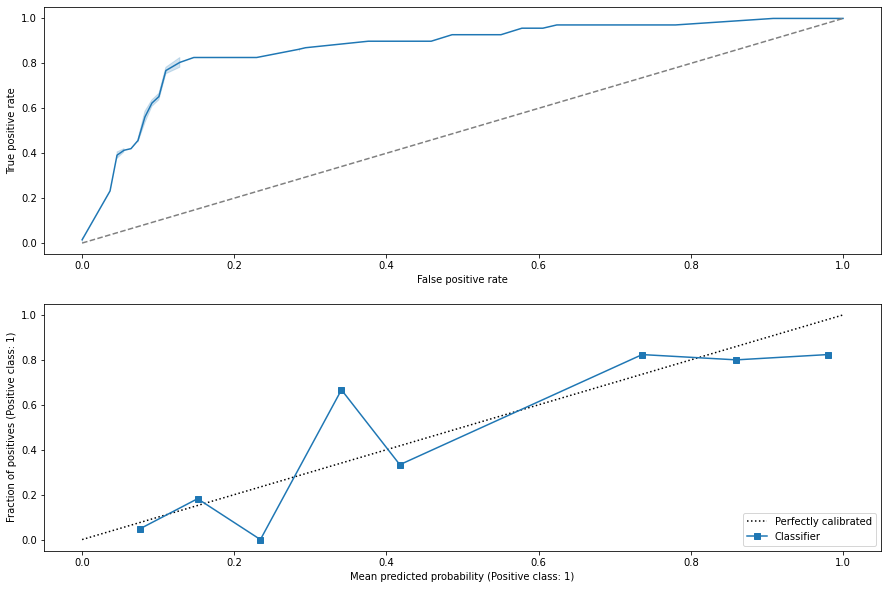

In [43]:
show_results(best_pipeline3, search3, X_train, y_train, X_test, y_test, visualize=True)

We see that accuracy in test set is 0.848 which is better than XGBClassifier had but the Kaggle result is the same as XGBClassifier and SVC had: 0.77751. Let's check what predictions were different in test set:

In [44]:
pred1 = best_pipeline.predict(X_test)
pred3 = best_pipeline3.predict(X_test)
X_test[pred1 != pred3]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Title_grouped,FamilySize,FamilySize_grouped,GroupSize,GroupSize_grouped,GroupRate,GroupRate_grouped,FamilyRate,FamilyRate_grouped,Fare_adjusted
PassengerId,,,,,,,,,,,,,,,,,,,,,
183,0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.000000,4,2,347077,31.3875,NaN,...,Master,7,2,7,2,0.750000,1,0.75,1,4.483929
769,0,3,"Moran, Mr. Daniel J",male,9.424242,1,0,371110,24.1500,NaN,...,Mr,2,1,3,1,0.333333,0,0.50,1,8.050000
849,0,2,"Harper, Rev. John",male,28.000000,0,1,248727,33.0000,NaN,...,Religious,2,1,3,1,0.666667,1,0.50,1,11.000000


Looks like only three predictions were different in test set. 

__Combining the estimators__

If the results are different we can try to combine estimators to an ensemble in order to gain better accuracy. Let's see if combining the three estimators give any better results:

In [45]:
def make_ensemble_pred(trained_clfs, X, depth):
    predictions = np.array([clf.predict(X) for clf in trained_clfs])
    avg_preds = np.round(np.mean(predictions, axis=0))

    for i in range(depth):
        for clf in trained_clfs:
            clf.fit(X, avg_preds)
        predictions = np.array([clf.predict(X) for clf in trained_clfs])
        avg_preds = np.round(np.mean(predictions, axis=0))
    
    return avg_preds

In [46]:
pred1 = best_pipeline.predict(X_test)
pred2 = best_pipeline2.predict(X_test)
pred3 = best_pipeline3.predict(X_test)

ens_pred = make_ensemble_pred([copy.deepcopy(best_pipeline),
                               copy.deepcopy(best_pipeline2),
                               copy.deepcopy(best_pipeline3)], 
                               X_test, 2)

print(f'Score in test set: {np.sum(ens_pred == y_test) / len(y_test)}')


/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown c

Score in test set: 0.8426966292134831


/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/dat

Looks like score in test set didn't improve that much. Finally, we can investigate if training the estimators with full training data (X_train + X_test) will change the ensemble results:

In [47]:
def predictions_for_passengers(X, ml_pipeline):
    predictions = pd.DataFrame(ml_pipeline.predict(X).astype(int), index=X.index, columns=['Survived'])
    return predictions

def ensemble_predictions_for_passengers(X, clfs, depth):
    predictions = make_ensemble_pred(clfs, X, depth)
    return pd.DataFrame(predictions.astype(int), index=X.index, columns=['Survived'])

In [48]:
pred1 = predictions_for_passengers(all_features_competition_data, best_pipeline)
pred2 = predictions_for_passengers(all_features_competition_data, best_pipeline2)
pred3 = predictions_for_passengers(all_features_competition_data, best_pipeline3)

pred_ens = ensemble_predictions_for_passengers(all_features_competition_data, 
                                           [copy.deepcopy(best_pipeline), copy.deepcopy(best_pipeline2), 
                                            copy.deepcopy(best_pipeline3)], 2)

best_pipeline.fit(all_features_training_data, all_features_training_data.loc[:, _LABEL])
best_pipeline2.fit(all_features_training_data, all_features_training_data.loc[:, _LABEL])
best_pipeline3.fit(all_features_training_data, all_features_training_data.loc[:, _LABEL])


pred1_full = predictions_for_passengers(all_features_competition_data, best_pipeline)
pred2_full = predictions_for_passengers(all_features_competition_data, best_pipeline2)
pred3_full = predictions_for_passengers(all_features_competition_data, best_pipeline3)

pred_ens_full = ensemble_predictions_for_passengers(all_features_competition_data, 
                                           [copy.deepcopy(best_pipeline), copy.deepcopy(best_pipeline2), 
                                            copy.deepcopy(best_pipeline3)], 2)


print(f'Changes between pred1 and pred2: {np.sum((pred1 != pred2).values)}')
print(f'Changes between pred1 and pred3: {np.sum((pred1 != pred3).values)}')
print(f'Changes between pred2 and pred3: {np.sum((pred2 != pred3).values)}')

print(f'''Ensemble changes: \n\t pred1: {np.sum((pred1 != pred_ens).values)}, 
\t pred2: {np.sum((pred2 != pred_ens).values)}, 
\t pred3: {np.sum((pred3 != pred_ens).values)}''')


print(f'Pred1 changes after fit: {np.sum((pred1 != pred1_full).values)}')
print(f'Pred2 changes after fit: {np.sum((pred2 != pred2_full).values)}')
print(f'Pred3 changes after fit: {np.sum((pred3 != pred3_full).values)}')

print(f'Changes between pred1 and pred2 after fit: {np.sum((pred1_full != pred2_full).values)}')
print(f'Changes between pred1 and pred3 after fit: {np.sum((pred1_full != pred3_full).values)}')
print(f'Changes between pred2 and pred3 after fit: {np.sum((pred2_full != pred3_full).values)}')


print(f'Ensemble changes after fit: {np.sum((pred_ens != pred_ens_full).values)}')

ens_pred_test = make_ensemble_pred([copy.deepcopy(best_pipeline),
                               copy.deepcopy(best_pipeline2),
                               copy.deepcopy(best_pipeline3)], 
                               X_test, 2)

print(f'Score in test set: {np.sum(ens_pred_test == y_test) / len(y_test)}')


om pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype inst

/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/dat

/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/dat

/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown c

Changes between pred1 and pred2: 0
Changes between pred1 and pred3: 2
Changes between pred2 and pred3: 2
Ensemble changes: 
	 pred1: 0, 
	 pred2: 0, 
	 pred3: 2
Pred1 changes after fit: 0
Pred2 changes after fit: 2
Pred3 changes after fit: 8
Changes between pred1 and pred2 after fit: 2
Changes between pred1 and pred3 after fit: 10
Changes between pred2 and pred3 after fit: 8
Ensemble changes after fit: 3


/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Score in test set: 0.8426966292134831


/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Looks like at first SVC and RandomForestClassifier made the same predictions to competition data whereas XGBClassifier made slightly different predictions. When refitting to full training data, RandomForestClassifier changed 8 predictions in competition data. Ensemble of these three classifiers didn't change after refit. In test set the accuracy of ensemble was 0.842 (after refit) but Kaggle score reached now the same level as the best of our simple benchmark classifiers, 0.77990. 



__Back to benchmark classifier__

Now that we have done some tuning for our estimators and Kaggle accuracy was just the same as with simple GroupByClassifier, we can also try to "tune" the GroupByClassifier to see if there's room for improvement. The only parameter GroupByClassifier takes is a list of columns to be used in groupby so we can try to find the optimal columns. Let's start by listing all categorical columns (only those can be grouped) and then forming all combinations of them that have length min_features <= L <= max_features. 

In [49]:
all_features_training_data.columns
cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'HasCabin', 'CabinType', 'Title_grouped',
        'FamilySize_grouped', 'GroupSize_grouped', 'GroupRate_grouped', 'FamilyRate_grouped']
min_features = 1
max_features = 5
features = []
for L in range(min_features, max_features + 1):
    for subset in itertools.combinations(cols, L):
        features.append(list(subset))
print(len(features))

1585


So there are in total 1585 column combinations of length 1 <= L <= 5 that we can try. So let's try to find the optimal one by using the standard GridSearchCV with Stratified 5-Fold cross-validation. As with the previous grid searches, the best parameter set (set of columns) is determined by the mean accuracy in validation sets. After the cross-validation results are formed we can test the best classifier in test set and send results Kaggle if test set results are good enough.

In [50]:
parameters = {'groupby_cols': features
             }

cv = StratifiedKFold(n_splits=5) 
search_gb = GridSearchCV(GroupByClassifier([]), param_grid=parameters, 
                        n_jobs=-1, cv=cv, verbose=0, scoring=['accuracy'], refit='accuracy')
search_gb.fit(X_train, y_train)
best_gb = search_gb.best_estimator_
print(f'Best params: {search_gb.best_params_}')
print(f'Best avg score in validation sets: {search_gb.best_score_}')
print(f'Score in train set: {best_gb.score(X_train, y_train)}')
print(f'Score in test set: {best_gb.score(X_test, y_test)}') # best 0.8427
pred_gb = predictions_for_passengers(all_features_competition_data, best_gb)

Best params: {'groupby_cols': ['Title_grouped', 'GroupSize_grouped', 'GroupRate_grouped', 'FamilyRate_grouped']}
Best avg score in validation sets: 0.8681768935290062
Score in train set: 0.8695652173913043
Score in test set: 0.8426966292134831


The best combination of columns according to validation sets is ['Title_grouped', 'GroupSize_grouped', 'GroupRate_grouped', 'FamilyRate_grouped']. However, in test set this combination got slightly lower accuracy (0.843) than the previously best GroupByClassifier (accuracy of 0.8596 with ['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped']). Kaggle results show also the same story: accuracy of this new "optimal" classifier is 0.77751, which is slightly worse than with the previously best GroupByClassifier (0.77990). We can finally check if predictions of the best GroupByClassifier for some of the groups could be easily improved with numerical columns, such as Age or Fare. First, we can check which groups have the highest improvement potential: 

In [51]:
cols_groupby = ['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped']

show_slice_results(groupby_clf, X_train, y_train, cols_groupby)
show_slice_results(groupby_clf, X_test, y_test, cols_groupby)

Survived  \
Title_grouped FamilySize_grouped FamilyRate_grouped                      
Master        1                  0                       (1.0, 2.0, 2)   
                                 1                     (1.0, 17.0, 17)   
              2                  0                      (0.0, 0.0, 15)   
                                 1                       (1.0, 1.0, 1)   
Miss          0                  1                    (0.77, 64.0, 83)   
              1                  0                       (0.0, 0.0, 9)   
                                 1                    (0.95, 37.0, 39)   
              2                  0                      (0.0, 0.0, 16)   
                                 1                       (1.0, 5.0, 5)   
Mr            0                  0                   (0.17, 54.0, 327)   
                                 1                       (0.0, 0.0, 1)   
              1                  0                     (0.12, 5.0, 42)   
                                 1                     (0.3, 14.0, 47)   
              2                  0                       (0.0, 0.0, 7)   
                                 1                       (0.0, 0.0, 1)   
Mrs           0                  1                    (0.86, 12.0, 14)   
              1                  0                      (0.0, 0.0, 12)   
                                 1                    (0.97, 60.0, 62)   
              2                  0                       (0.0, 0.0, 6)   
                                 1                       (1.0, 2.0, 2)   
Religious     0                  0                       (0.0, 0.0, 4)   
              1                  0                       (0.0, 0.0, 1)   

                                                         Predictions  \
Title_grouped FamilySize_grouped FamilyRate_grouped                    
Master        1                  0                     (1.0, 2.0, 2)   
                                 1                   (1.0, 17.0, 17)   
              2                  0                    (0.0, 0.0, 15)   
                                 1                     (1.0, 1.0, 1)   
Miss          0                  1                   (1.0, 83.0, 83)   
              1                  0                     (0.0, 0.0, 9)   
                                 1                   (1.0, 39.0, 39)   
              2                  0                    (0.0, 0.0, 16)   
                                 1                     (1.0, 5.0, 5)   
Mr            0                  0                   (0.0, 0.0, 327)   
                                 1                     (0.0, 0.0, 1)   
              1                  0                    (0.0, 0.0, 42)   
                                 1                    (0.0, 0.0, 47)   
              2                  0                     (0.0, 0.0, 7)   
                                 1                     (0.0, 0.0, 1)   
Mrs           0                  1                   (1.0, 14.0, 14)   
              1                  0                    (0.0, 0.0, 12)   
                                 1                   (1.0, 62.0, 62)   
              2                  0                     (0.0, 0.0, 6)   
                                 1                     (1.0, 2.0, 2)   
Religious     0                  0                     (0.0, 0.0, 4)   
              1                  0                     (0.0, 0.0, 1)   

                                                               Failure  
Title_grouped FamilySize_grouped FamilyRate_grouped                     
Master        1                  0                       (0.0, 0.0, 2)  
                                 1                      (0.0, 0.0, 17)  
              2                  0                      (0.0, 0.0, 15)  
                                 1                       (0.0, 0.0, 1)  
Miss          0                  1                    (0.23, 19.0, 83)  
              1                  0           

Survived  \
Title_grouped FamilySize_grouped FamilyRate_grouped                     
Master        1                  0                      (1.0, 2.0, 2)   
                                 1                      (1.0, 1.0, 1)   
              2                  0                      (0.0, 0.0, 1)   
                                 1                      (0.0, 0.0, 1)   
Miss          0                  1                   (0.73, 16.0, 22)   
              1                  1                    (0.82, 9.0, 11)   
              2                  0                      (0.0, 0.0, 1)   
                                 1                      (1.0, 1.0, 1)   
Mr            0                  0                    (0.12, 9.0, 78)   
                                 1                      (1.0, 1.0, 1)   
              1                  0                    (0.14, 3.0, 22)   
                                 1                      (0.0, 0.0, 2)   
              2                  0                      (0.0, 0.0, 2)   
                                 1                      (0.0, 0.0, 1)   
Mrs           0                  1                      (1.0, 7.0, 7)   
              1                  1                   (0.86, 19.0, 22)   
              2                  0                      (0.0, 0.0, 1)   
                                 1                      (1.0, 1.0, 1)   
Religious     1                  1                      (0.0, 0.0, 1)   

                                                         Predictions  \
Title_grouped FamilySize_grouped FamilyRate_grouped                    
Master        1                  0                     (1.0, 2.0, 2)   
                                 1                     (1.0, 1.0, 1)   
              2                  0                     (0.0, 0.0, 1)   
                                 1                     (1.0, 1.0, 1)   
Miss          0                  1                   (1.0, 22.0, 22)   
              1                  1                   (1.0, 11.0, 11)   
              2                  0                     (0.0, 0.0, 1)   
                                 1                     (1.0, 1.0, 1)   
Mr            0                  0                    (0.0, 0.0, 78)   
                                 1                     (0.0, 0.0, 1)   
              1                  0                    (0.0, 0.0, 22)   
                                 1                     (0.0, 0.0, 2)   
              2                  0                     (0.0, 0.0, 2)   
                                 1                     (0.0, 0.0, 1)   
Mrs           0                  1                     (1.0, 7.0, 7)   
              1                  1                   (1.0, 22.0, 22)   
              2                  0                     (0.0, 0.0, 1)   
                                 1                     (1.0, 1.0, 1)   
Religious     1                  1                     (0.0, 0.0, 1)   

                                                             Failure  
Title_grouped FamilySize_grouped FamilyRate_grouped                   
Master        1                  0                     (0.0, 0.0, 2)  
                                 1                     (0.0, 0.0, 1)  
              2                  0                     (0.0, 0.0, 1)  
                                 1                     (1.0, 1.0, 1)  
Miss          0                  1                   (0.27, 6.0, 22)  
              1                  1                   (0.18, 2.0, 11)  
              2                  0                     (0.0, 0.0, 1)  
                                 1                     (0.0, 0.0, 1)  
Mr            0                  0                   (0.12, 9.0, 78)  
                                 1                     (1.0, 1.0, 1)  
              1                  0                   (0.14, 3.0, 22)  
                                 1                     (0.0, 0.0, 2)  
              2     

Looks like groups (Title_grouped='Mr', FamilySize_grouped=0, FamilyRate_grouped=0) and (Title_grouped='Miss', FamilySize_grouped=0, FamilyRate_grouped=1) have the biggest potential when it comes to number of failed predictions in train/test set. Let's check how Age and Fare distributions look in those groups:

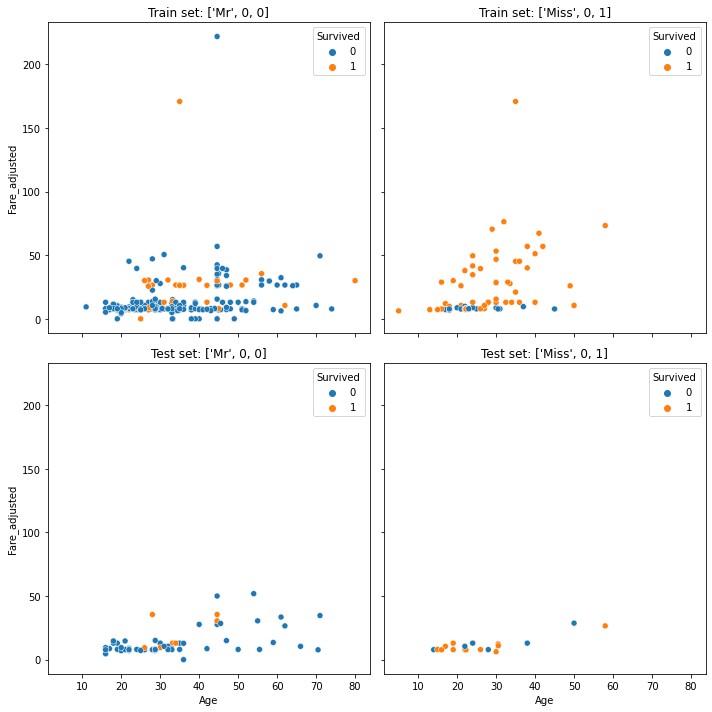

In [52]:
data_labels_list = [(X_train, y_train), (X_test, y_test)]
groups = [['Mr', 0, 0], ['Miss', 0, 1]]
fig, ax = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)

for i, (data, labels) in enumerate(data_labels_list): 
    for j, group in enumerate(groups):       
        ax[i][j].set_title(f'Train set: {group}' if i==0 else f'Test set: {group}')
        index = data['Survived'] > -1 # all trues
        for k, col in enumerate(cols_groupby):
            index &= (data[col] == group[k])  # add desired value of each column to condition

        sns.scatterplot(data=data[index], x='Age', y='Fare_adjusted', hue='Survived', ax=ax[i][j])
plt.tight_layout()


Looks like there are no crystal clear survival patterns for Age or Fare but one could try for example to predict Survived=0 for ('Miss', 0, 1) passengers if Age > 16 and Fare_adjusted < 9.9. Let's do this manual rule soon unless DecisionTreeClassifier can find something from Age and Fare_adjusted columns for ('Miss', 0, 1). 

We will now use ModifiedGroupByClassifier (see training_utils.py) that does the same as GroupByClassifier but it also finetunes predictions of some special group (e.g. ('Miss', 0, 1)) by classifier that is specified for that group in 'special_group_clfs' parameter. The columns used in by the classifier are specified in parameter 'special_group_features'. Now we will use DecisionTreeClassifier as the classifier and we also add a preprocessing step before the estimator (so that other classifiers could be used as well if needed). Let's see what results we get now: 

In [53]:
group = ('Miss', 0, 1)
candidate_pipelines = [Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('estimator', DecisionTreeClassifier(random_state=5, max_depth=d, splitter='random', min_samples_leaf=msl))   
]) for d in [1, 2, 3, 4, 5] for msl in [1, 3, 5, 10]]

parameters = {'groupby_cols': [['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped']],
              'special_group_clfs': [{ group: candidate_pipeline} for candidate_pipeline in candidate_pipelines],
              'special_group_features': [{ group: ['Age', 'Fare_adjusted']}]
             }

cv = StratifiedKFold(n_splits=5) 
search_gb = GridSearchCV(ModifiedGroupByClassifier([], [], []), param_grid=parameters, 
                        n_jobs=-1, cv=cv, verbose=0, scoring=['accuracy'], refit='accuracy')
search_gb.fit(X_train, y_train)
best_gb = search_gb.best_estimator_
print(f'Best params: {search_gb.best_params_}')
print(f'Best avg score in validation sets: {search_gb.best_score_}')
print(f'Score in train set: {best_gb.score(X_train, y_train)}')
print(f'Score in test set: {best_gb.score(X_test, y_test)}') 
pred_gb = predictions_for_passengers(all_features_competition_data, best_gb)


Best params: {'groupby_cols': ['Title_grouped', 'FamilySize_grouped', 'FamilyRate_grouped'], 'special_group_clfs': {('Miss', 0, 1): Pipeline(steps=[('scaling', StandardScaler()),
                ('estimator',
                 DecisionTreeClassifier(max_depth=3, min_samples_leaf=3,
                                        random_state=5, splitter='random'))])}, 'special_group_features': {('Miss', 0, 1): ['Age', 'Fare_adjusted']}}
Best avg score in validation sets: 0.8667585935191567
Score in train set: 0.8695652173913043
Score in test set: 0.8539325842696629


Looks like the changes DecisionTreeClassifier did for ('Miss', 0, 1) group reduced test set accuracy compared to GroupByClassifier accuracy. However, test set is now quite small and it doesn't necessary tell everything; mean accuracy in validation sets was pretty high. Let's plot the decision tree and decision boundary of the classifier to see what logic it used:

In [54]:
def show_decision_boundary(X, y, clf):
    fig, ax = plt.subplots(1,1)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        grid_resolution=200,
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=X.columns[0],
        ylabel=X.columns[1],
    )
    ax.scatter(X[X.columns[0]], X[X.columns[1]], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")


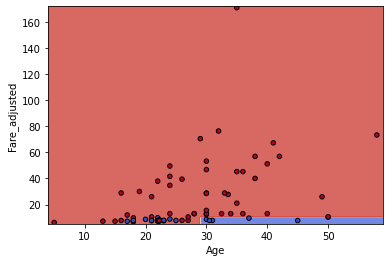

In [55]:
X, y = X_train.copy(deep=True), y_train.copy(deep=True)
indices = best_gb.form_group_indices(X, group)
X_group, y_group = X[indices], y[indices]
show_decision_boundary(X_group[['Age', 'Fare_adjusted']], y_group, best_gb.special_group_clfs[group])

[Text(0.6, 0.875, 'X[1] <= -0.466\ngini = 0.353\nsamples = 83\nvalue = [19, 64]'),
 Text(0.4, 0.625, 'X[0] <= -0.33\ngini = 0.497\nsamples = 41\nvalue = [19, 22]'),
 Text(0.2, 0.375, 'gini = 0.478\nsamples = 33\nvalue = [13, 20]'),
 Text(0.6, 0.375, 'X[0] <= 0.17\ngini = 0.375\nsamples = 8\nvalue = [6, 2]'),
 Text(0.4, 0.125, 'gini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.8, 0.125, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.8, 0.625, 'gini = 0.0\nsamples = 42\nvalue = [0, 42]')]

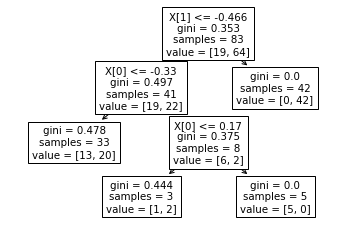

/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/xgboost/dat

/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/Johan/anaconda/envs/conda_env_38/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [56]:
plot_tree(best_gb.special_group_clfs[group][-1])

Looks like DecisionTreeClassifier chose a bit different splitting logic than our manual rule. Decision boundary for this classifier looks though a bit similar to our manual rule and the rule sounds reasonable, so let's see what Kaggle score this new classifier gets.

Surprisingly, Kaggle score was __0.78468__ which is the best score so far! And this was obtained using the new classifier fit on X_train only. We can try to get even better results by fitting the classifier to full training set: all_features_training_data that contains both X_train and X_test. Fitting to full training data indeed improved the results even more: now the new best Kaggle score is __0.78708__! Looks like there was room for improvement for ('Miss', 0, 1) group, at least as far as Kaggle score is considered. 


__Possible next steps__

In this notebook, the best score was achieved by using ModifiedGroupByClassifier which basically does the same as GroupByClassifier does but it finetunes the predictions for (Title_grouped='Miss', 'FamilySize_grouped'=0, 'FamilyRate_grouped'=1) group by using a DecisionTreeClassifier that predicts based on 'Age' and 'Fare_adjusted' columns. This classifier ranked at place 906-1282 / 13143 (top 10 %) in Kaggle leaderboard with score 0.78708. 

To improve the score, one could check the other groups as well to see if there's some low hanging fruits. There are also lot of improvements to be done for estimators (e.g. calibrating all classfiers using CalibratedClassifierCV, using other classifiers, using more ensembling and doing better hyperparameter tuning) but probably one of the most important improvement step would be related to feature engineering. There are probably some key features that we didn't consider in the feature engineering part. One easy step would be to split Age and Fare columns to groups and see if that can help classifiers to use these columns more effectively. 

Also, usually in production setting there should be a clear goal where to aim for when implementing ML models. Now, the goal is to get better Kaggle result, but that seems to be quite vague goal because we don't have better understanding on the distributions of Kaggles evaluation subset (e.g. is it important to improve Master predictions or Mr predictions). In order to improve results and to understand what to improve, this subset could be investigated. However, this kind of information gathering has the risk of getting too much information about the evaluation set. For example, when you know the labels you can just choose the model that you know will perform the best in evaluation set although it would be inaccurate at training/test data. This kind of tweaking is quite far from ML usage in production and so we don't go that path in this notebook.

Having over 13000 participants, the Kaggle Titanic competition has pretty huge community and there are lot of hints available how you can try to improve the accuracy. Although the idea of this notebook was to try to learn and figure out things by myself as much as possible, I got some good hints from Kaggle discussions, especially related to feature engineering. If you have some nice improvement ideas please don't hesitate to share them with me!
